# Library


In [1]:

import os
from config import get_config,update_config
import numpy as np
import torch
import os
import cv2
import torchvision.transforms as transforms
try:
    from apex import amp
except ImportError:
    print("AMP is not available")
from datasets.predict_loader import test_loader
from datasets.extract_depth_gazefollow import extract_depth
from models import get_model, load_pretrained
from utils import get_memory_format
import matplotlib.pyplot as plt
from tqdm import tqdm

AMP is not available


In [3]:
def predict_videos(vid_dirs, save_dir, device="cuda",freq):
# vid_dirs: A list, contains all videos address
# ====== Output =======
for vid in vid_dirs:
    save_sub_dir="videoname without ext"
    predict_video(vid,save_sub_dir,device=device,freq=freq)


def predict_video(vid_dir, save_dir, device="cuda",freq):
# vid_dirs: video address (absolute)
# ====== Output =======
get_videotype(vid_dir)
print(detect video xxx, print meta information)

create a  file called temp under save_dir
extract video2Image(vid_dir, temp, freq)

predict_image(temp, "ALL", plot=True, heatmap=True, Demo=True, device="cuda")






IndentationError: expected an indented block after function definition on line 1 (517861323.py, line 4)

# Function

======Loading Config======
Running on cuda
======Loading dataset======
======Loading model======
Total params: 92183098
Total trainable params: 92183098
<All keys matched successfully>
======Process Depth======
initialize
device: cuda
start processing

 Working on folder D:\Datasets\engagement_follow\image_original
6


6it [00:01,  3.34it/s]


finished
======Prediction======


0it [00:00, ?it/s]

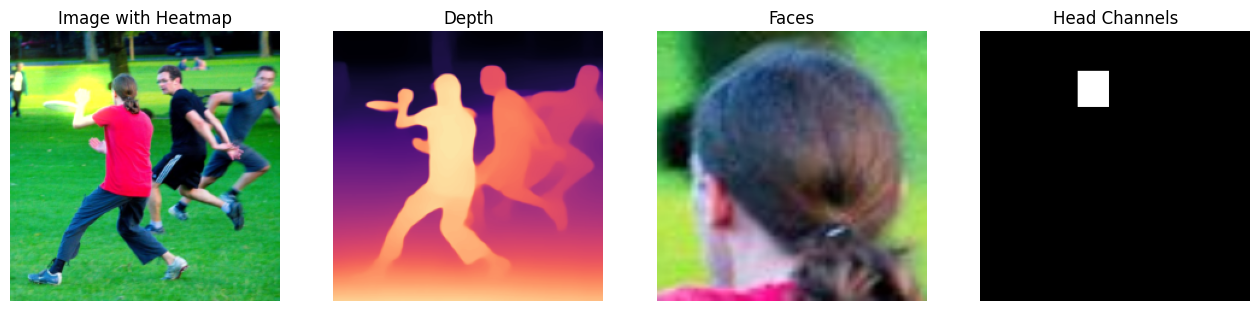

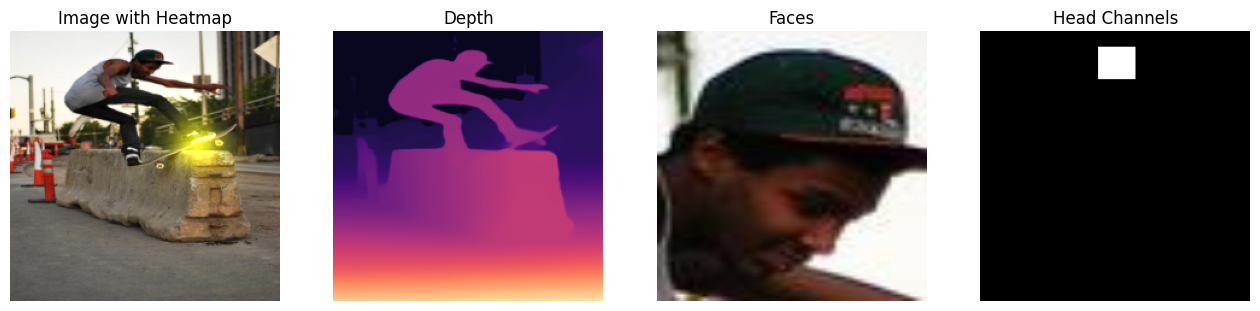

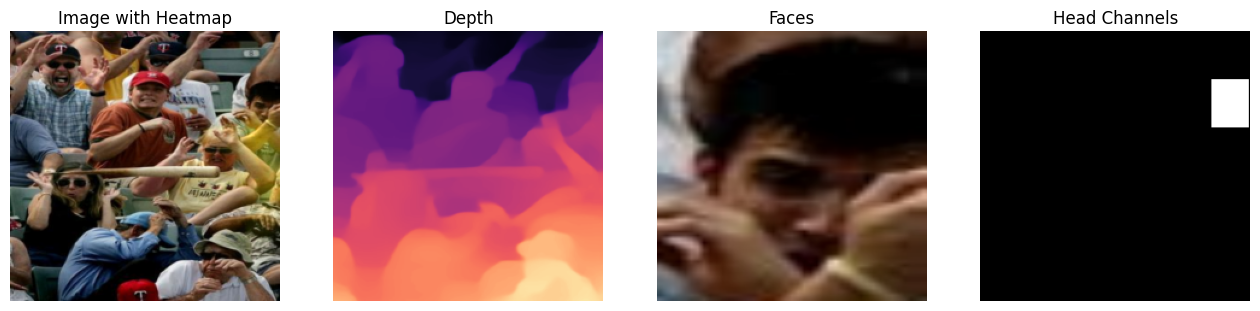

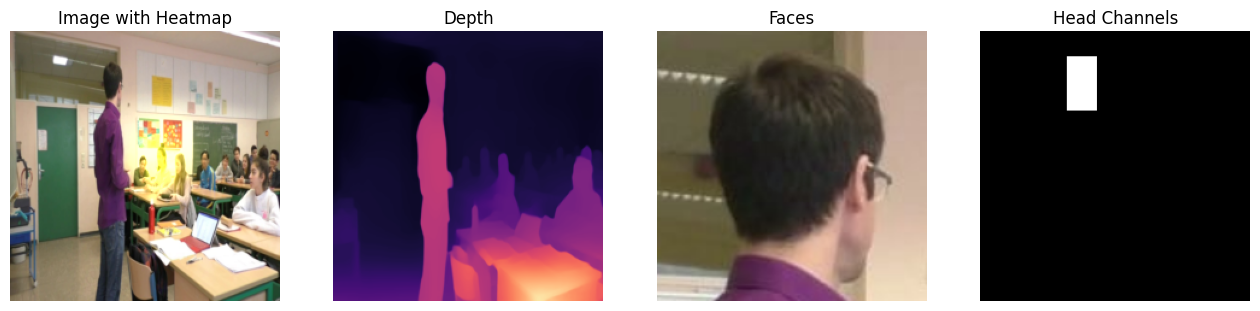

1it [00:05,  5.52s/it]

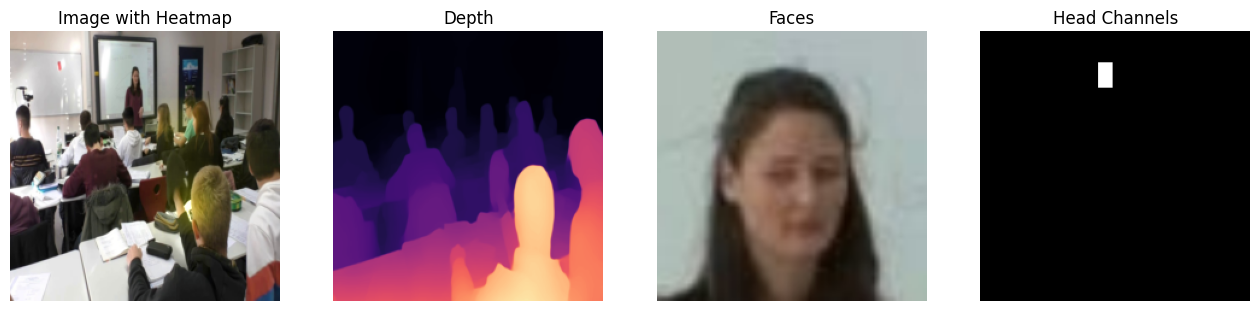

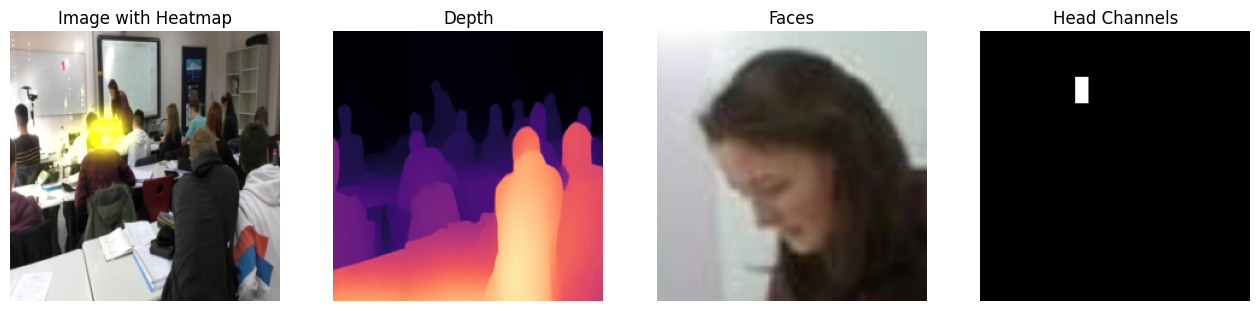

2it [00:07,  3.53s/it]

ALl finished


In [3]:
def composition_image(image_path, image, gaze_heatmap_pred, depth, face, head_channel,demo_dir):

    # heatmap, original image, depth --> Saving the composite image demo
    composite_img = np.zeros((448, 448, 3), dtype=np.uint8) # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    original_image = image.cpu() * std + mean
    original_image = original_image[0][[0, 1, 2], :, :]
    original_image = transforms.ToPILImage()(original_image).convert("RGB")
    original_image = np.array(original_image.resize((224, 224)))
    heatmap_image_resized = gaze_heatmap_pred.resize((224, 224))
    heatmap_image_resized = np.array(heatmap_image_resized)
    heatmap_image_resized = np.stack([heatmap_image_resized * 1, heatmap_image_resized* 1, heatmap_image_resized * 0], axis=2)
    masked_image = cv2.addWeighted(original_image, 1, heatmap_image_resized, 2, 0)
    composite_img[0:224, 0:224, :] = masked_image

    # LEFT DOWN: Depths image
    depths_image = transforms.ToPILImage()(depth.cpu()).convert("RGB")
    depths_image = np.array(depths_image.resize((224, 224)))
    composite_img[224:448, 0:224, :] = depths_image

    # RIGHT UP: Faces image
    faces_image = face.cpu()* std + mean
    faces_image = faces_image[0][[0, 1, 2], :, :]
    faces_image = transforms.ToPILImage()(faces_image).convert("RGB")
    faces_image = np.array(faces_image.resize((224, 224)))
    composite_img[0:224, 224:448, :] = faces_image

    # RIGHT DOWN: Head_channels image (grayscale)
    head_channels_image = transforms.ToPILImage()(head_channel.cpu()).convert("L")
    head_channels_image = np.array(head_channels_image.resize((224, 224)))
    composite_img[224:448, 224:448, 0] = head_channels_image
    composite_img[224:448, 224:448, 1] = head_channels_image
    composite_img[224:448, 224:448, 2] = head_channels_image
    # Save composite_img
    composite_file_name = f"composite_{os.path.basename(image_path)}"
    cv2.imwrite(os.path.join(demo_dir, composite_file_name), cv2.cvtColor(composite_img, cv2.COLOR_RGB2BGR))


def plot_image(image, gaze_heatmap_pred, depth, face, head_channel):

    plt.figure(figsize=(16, 4))

    # Original Image with Heatmap
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    original_image = image.cpu() * std + mean
    original_image = original_image[0][[0, 1, 2], :, :]
    original_image = transforms.ToPILImage()(original_image).convert("RGB")
    original_image = np.array(original_image.resize((224, 224)))
    heatmap_image_resized = np.array(gaze_heatmap_pred.resize((224, 224)))
    heatmap_image_resized = np.stack([heatmap_image_resized, heatmap_image_resized, 0 * heatmap_image_resized], axis=2)
    masked_image = cv2.addWeighted(original_image, 1, heatmap_image_resized, 2, 0)
    plt.subplot(1, 4, 1)
    plt.imshow(masked_image)
    plt.title("Image with Heatmap")
    plt.axis("off")

    # Depth Image
    depths_image = transforms.ToPILImage()(depth.cpu()).convert("RGB")
    depths_image = np.array(depths_image.resize((224, 224)))
    plt.subplot(1, 4, 2)
    plt.imshow(depths_image)
    plt.title("Depth")
    plt.axis("off")

    # Faces Image
    faces_image = face.cpu() * std + mean
    faces_image = faces_image[0][[0, 1, 2], :, :]
    faces_image = transforms.ToPILImage()(faces_image).convert("RGB")
    faces_image = np.array(faces_image.resize((224, 224)))
    plt.subplot(1, 4, 3)
    plt.imshow(faces_image)
    plt.title("Faces")
    plt.axis("off")

    # Head Channels Image
    head_channels_image = transforms.ToPILImage()(head_channel.cpu()).convert("L")
    head_channels_image = np.array(head_channels_image.resize((224, 224)))
    plt.subplot(1, 4, 4)
    plt.imshow(head_channels_image, cmap='gray')
    plt.title("Head Channels")
    plt.axis("off")

    plt.show()


def predict_image(dataset_dir, image_list, device="cuda",plot=True, heatmap=True, Demo=True):

# dataset_dir: The Dir should in style of gazefollow, that contains head_information.txt and file named image_original contains all images
# checkpoint_dir: The dir of model weight.
# image_list: A list of image name, should be same with first column in file test_annotations_release.txt. If image_name=“ALL”, it process all image detected.
# ====== Output =======
# if plot, only plot the result 2 image per row;
# if heatmap, save heatmap prediction to heatmap_predict under dataset_dir;
# if demo, save square diagram into heatmap_predict under dataset_dir.


# Get config
    print("======Loading Config======")
    config= get_config()
    config= update_config(config,dataset_dir, device)
    device = torch.device(config.device)
    print(f"Running on {device}")

# Make Datasets
    print("======Loading dataset======")
    target_test_loader = test_loader(config,image_list)

# Load model
    print("======Loading model======")
    model = get_model(config, device=device)
    pretrained_dict = torch.load(config.eval_weights, map_location=device)
    pretrained_dict = pretrained_dict.get("model_state_dict") or pretrained_dict.get("model")
    model = load_pretrained(model, pretrained_dict)

# Process Depth File
    print("======Process Depth======")
    input_path=os.path.join(dataset_dir,"image_original")
    output_path=os.path.join(dataset_dir,"depth_intermediate")
    model_weights="weights\\dpt_large-midas-2f21e586.pt"
    extract_depth(input_path, output_path, model_weights, "dpt_large", "no-optimize", image_list)

# Prediction (dataloader, model, config --> saved image prediction)
    print("======Prediction======")
    model.eval()
    gaze_inside_all = []
    gaze_inside_pred_all = []
    # # Prediction (dataloader, model, config --> batched prediction array)
    with torch.no_grad():
        for batch, data in tqdm(enumerate(target_test_loader)):
            (
                images,
                depths,
                faces,
                head_channels,
                _,
                eye_coords,     #label information
                gaze_coords,    #label information
                gaze_inside,    #label information
                img_size,
                path,
            ) = data
            images = images.to(device, non_blocking=True, memory_format=get_memory_format(config))
            depths = depths.to(device, non_blocking=True, memory_format=get_memory_format(config))
            faces = faces.to(device, non_blocking=True, memory_format=get_memory_format(config))
            head = head_channels.to(device, non_blocking=True, memory_format=get_memory_format(config))
            gaze_inside = gaze_inside.to(device, non_blocking=True, memory_format=get_memory_format(config))
            gaze_heatmap_pred, gaze_inside_pred, _, _, _ = model(images, depths, head, faces)
            gaze_inside_all.extend(gaze_inside.cpu().tolist())
            gaze_inside_pred_all.extend(gaze_inside_pred.squeeze(1).cpu().tolist())
            gaze_heatmap_pred = gaze_heatmap_pred.squeeze(1).cpu()

    # # Prediction (batched prediction array --> save)
            # Define the directory where you want to save the predicted images
            heatmap_dir = os.path.join(config.dataset_dir,"predict_heatmap")
            demo_dir = os.path.join(config.dataset_dir,"predict_demo")
            os.makedirs(heatmap_dir, exist_ok=True)  # Ensure the directory exists
            os.makedirs(demo_dir, exist_ok=True)  # Ensure the directory exists

            # heatmap array, Address --> Saving the gaze_heatmap_pred image
            for i, image_path in enumerate(path):

                heatmap_image = gaze_heatmap_pred[i]
                heatmap_image = transforms.ToPILImage()(heatmap_image)

                if heatmap:
                    heatmap_image.save(os.path.join(heatmap_dir, os.path.basename(image_path)))

                if plot:
                    plot_image(images[i], heatmap_image, depths[i], faces[i], head_channels[i])

                if Demo:
                    composition_image(image_path, images[i], heatmap_image, depths[i], faces[i], head_channels[i],demo_dir)
    print("ALl finished")
predict_image(r"D:\Datasets\engagement_follow","ALL")

In [ ]:

predict_image(r"D:\Datasets\engagement_follow","ALL")

#predict_image(r"D:\Datasets\engagement_follow",["image_original/00000004.jpg"])

# Prediction

In [7]:
print(heatmap_image)


<PIL.Image.Image image mode=L size=64x64 at 0x24454732810>
